In [1]:
import timm
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.__version__

'2.6.0+cu118'

In [3]:
## GLOBAL 

CHANNELS = 3 
N_CLASSES = 1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda:0


In [4]:
import os
from torchvision import datasets, transforms
import torch

print(f"Step 1: Loading dataset with resize transform...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) 
])

val_data_dir = 'dataset/imagenet_validation' 
test_data_dir = 'dataset/imagenet_tests'

val_dataset = datasets.ImageFolder(os.path.join(val_data_dir), transform=transform) 

test_datasets = {
    f'test{i}': datasets.ImageFolder(os.path.join(test_data_dir, f'test{i}'), transform=transform)
    for i in range(1, 11)
}

print(f"Validation samples: {len(val_dataset)}")
print(f"Validation samples: {len(test_datasets['test1'])}")

Step 1: Loading dataset with resize transform...
Validation samples: 30000
Validation samples: 2000


In [5]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4) 
test_loader = DataLoader(test_datasets['test1'], batch_size=1, shuffle=False, num_workers=4)  

### Base Models 

In [50]:
def evaluate_pool(pool, test_loader):
    print("\nEvaluating individual classifiers on test set...")

    for i, model in enumerate(pool):
        model = model.to(device)  # <- Ensure model is on the correct device
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.numel()
        acc = correct / total * 100
        print(f"Classifier {i+1} ({model.__class__.__name__}): Accuracy = {acc:.2f}%")


from collections import Counter
import pandas as pd

def evaluate_pool_with_consensus(pool, test_loader):
    print("\nEvaluating individual classifiers and consensus...")

    num_classifiers = len(pool)
    total_samples = 0
    correct_matrix = []

    for i, model in enumerate(pool):
        model = model.to(device)
        model.eval()

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
            batch_size = imgs.size(0)
            total_samples += batch_size

            batch_corrects = torch.zeros((len(pool), batch_size), dtype=torch.bool)

            for i, model in enumerate(pool):
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                batch_corrects[i] = preds == labels

            correct_matrix.append(batch_corrects)

    # Stack across all batches -> shape: (num_classifiers, total_samples)
    correct_matrix = torch.cat(correct_matrix, dim=1)

    # Count how many models got each sample correct
    consensus_counts = correct_matrix.sum(dim=0).cpu().numpy()  # shape: (total_samples,)
    consensus_distribution = Counter(consensus_counts)

    # Get indices for 0 and 1 correct predictions
    only_one_model_indices = [i for i, count in enumerate(consensus_counts) if count == 1]
    zero_model_indices = [i for i, count in enumerate(consensus_counts) if count == 0]

    # Print table
    print("\nConsensus Accuracy Table:")
    print(f"{'Models Correct':>15} | {'# Samples':>10}")
    print("-" * 30)
    for i in range(num_classifiers, -1, -1):  # include 0
        count = consensus_distribution.get(i, 0)
        print(f"{i:>15} | {count:>10}")
    print("-" * 30)
    print(f"{'Total Samples':>15} | {total_samples:>10}")

    # Print detailed list of samples found by 1 or 0 models
    print(f"\n Indices of samples found by only 1 model: {only_one_model_indices}")
    print(f"   Total: {len(only_one_model_indices)}")

    print(f"\n Indices of samples found by 0 models: {zero_model_indices}")
    print(f"   Total: {len(zero_model_indices)}")

    return only_one_model_indices, zero_model_indices  # optional: return them for further use

In [7]:
from torchvision.models import (
    resnet18, resnet34,  
    resnet50, resnet101, resnet152, vgg11, vgg19,
    densenet201, inception_v3, googlenet, efficientnet_b0,
    squeezenet1_1, shufflenet_v2_x1_0, mobilenet_v2, convnext_tiny
)
from torchvision.models.vision_transformer import vit_b_16 
import timm  

In [10]:
trained_pool = [
        vgg19(pretrained=True).eval(),
        inception_v3(pretrained=True).eval(),
        googlenet(pretrained=True, aux_logits=True, transform_input=False).eval(), 
        mobilenet_v2(pretrained=True).eval(), 
        efficientnet_b0(pretrained=True).eval(), 
        # resnet18(pretrained=True).eval(),
        # resnet34(pretrained=True).eval(),
        resnet50(pretrained=True).eval(),
        resnet101(pretrained=True).eval()
         
       ]

In [11]:
evaluate_pool(trained_pool, test_loader)


Evaluating individual classifiers on test set...
Classifier 1 (VGG): Accuracy = 69.30%
Classifier 2 (Inception3): Accuracy = 66.40%
Classifier 3 (GoogLeNet): Accuracy = 56.55%
Classifier 4 (MobileNetV2): Accuracy = 67.70%
Classifier 5 (EfficientNet): Accuracy = 75.55%
Classifier 6 (ResNet): Accuracy = 73.50%
Classifier 7 (ResNet): Accuracy = 75.50%


In [51]:
evaluate_pool_with_consensus(trained_pool, test_loader)


Evaluating individual classifiers and consensus...

Consensus Accuracy Table:
 Models Correct |  # Samples
------------------------------
              7 |        862
              6 |        298
              5 |        162
              4 |        120
              3 |         88
              2 |         99
              1 |        116
              0 |        255
------------------------------
  Total Samples |       2000

 Indices of samples found by only 1 model: [12, 14, 66, 73, 97, 155, 248, 249, 268, 302, 333, 345, 379, 381, 387, 403, 406, 440, 461, 473, 480, 493, 530, 556, 560, 564, 570, 581, 605, 618, 762, 785, 790, 796, 814, 836, 859, 902, 906, 909, 916, 920, 928, 929, 989, 991, 995, 998, 1011, 1062, 1072, 1078, 1100, 1144, 1148, 1157, 1165, 1168, 1171, 1177, 1185, 1190, 1199, 1229, 1240, 1277, 1303, 1311, 1325, 1329, 1331, 1343, 1347, 1360, 1372, 1373, 1379, 1408, 1411, 1417, 1429, 1436, 1453, 1458, 1519, 1530, 1546, 1555, 1602, 1636, 1654, 1656, 1662, 1684, 1689, 1699, 1

([12,
  14,
  66,
  73,
  97,
  155,
  248,
  249,
  268,
  302,
  333,
  345,
  379,
  381,
  387,
  403,
  406,
  440,
  461,
  473,
  480,
  493,
  530,
  556,
  560,
  564,
  570,
  581,
  605,
  618,
  762,
  785,
  790,
  796,
  814,
  836,
  859,
  902,
  906,
  909,
  916,
  920,
  928,
  929,
  989,
  991,
  995,
  998,
  1011,
  1062,
  1072,
  1078,
  1100,
  1144,
  1148,
  1157,
  1165,
  1168,
  1171,
  1177,
  1185,
  1190,
  1199,
  1229,
  1240,
  1277,
  1303,
  1311,
  1325,
  1329,
  1331,
  1343,
  1347,
  1360,
  1372,
  1373,
  1379,
  1408,
  1411,
  1417,
  1429,
  1436,
  1453,
  1458,
  1519,
  1530,
  1546,
  1555,
  1602,
  1636,
  1654,
  1656,
  1662,
  1684,
  1689,
  1699,
  1714,
  1750,
  1751,
  1771,
  1775,
  1788,
  1813,
  1823,
  1847,
  1851,
  1856,
  1891,
  1897,
  1920,
  1929,
  1939,
  1953,
  1957,
  1996,
  1999],
 [16,
  29,
  37,
  55,
  60,
  64,
  81,
  90,
  93,
  116,
  119,
  120,
  121,
  137,
  143,
  147,
  158,
  228,
  236,


In [14]:
862 + 298 + 162 + 120 + 88 + 99 + 116

1745

In [15]:
1745 / 2000

0.8725

### VisionDES

In [46]:
from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


class VisionDES: 
    def __init__(self, dsel_dataset, pool): 
        self.dsel_dataset = dsel_dataset
        self.dsel_loader = DataLoader(dsel_dataset, batch_size=32, shuffle=False) 
        self.dino_model = timm.create_model('vit_base_patch16_224.dino', pretrained=True).to(device)
        self.dino_model.eval()  
        self.pool = pool 

        self.suspected_model_votes = [] 
        
        
    def dino_embedder(self, images):
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        return self.dino_model.forward_features(images)


    def visualize_test_and_roc(self, test_img, roc_imgs, local_labels, class_names=None):
        def denormalize(img_tensor, mean, std):
            mean = torch.tensor(mean).view(-1, 1, 1).to(img_tensor.device)
            std = torch.tensor(std).view(-1, 1, 1).to(img_tensor.device)
            return img_tensor * std + mean
        """
        Display test image and its Region of Competence (RoC) images with labels.
        
        Args:
            test_img (torch.Tensor): Shape (C, H, W)
            roc_imgs (torch.Tensor): Shape (k, C, H, W)
            local_labels (np.ndarray): Shape (k,)
            class_names (list): Optional list of class names
        """
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225] 

        k = roc_imgs.size(0)
        ncols = min(k, 5)
        nrows = 1 + (k + ncols - 1) // ncols  # one row for test image + RoC images
    
        plt.figure(figsize=(3 * ncols, 3 * nrows))
    
        # Plot test image
        plt.subplot(nrows, ncols, 1)
        denorm_img = denormalize(test_img, mean, std).clamp(0, 1)
        img_np = TF.to_pil_image(denorm_img.cpu())
        plt.imshow(img_np)
        plt.title("Test Image")
        plt.axis("off")
    
        # Plot RoC images
        for i in range(k):
            plt.subplot(nrows, ncols, i + 2)
            denorm_img = denormalize(roc_imgs[i], mean, std).clamp(0, 1)
            img_np = TF.to_pil_image(denorm_img.cpu())
            label = local_labels[i]
            if class_names:
                label = class_names[label]
            plt.imshow(img_np)
            plt.title(f"RoC #{i+1}\nLabel: {label}")
            plt.axis("off")
    
        plt.tight_layout()
        plt.show()
        

    def fit(self): 
        dsel_embeddings = []
        dsel_labels = []
    
        with torch.no_grad():
            for imgs, labels in tqdm(self.dsel_loader):
                imgs = imgs.to(device)
                embs = self.dino_embedder(imgs).cpu()  
                dsel_embeddings.append(embs)
                dsel_labels.append(labels)
    
        # Keep as tensor
        dsel_embeddings_tensor = torch.cat(dsel_embeddings).detach().cpu()  
        cls_tensor = dsel_embeddings_tensor[:, 0, :]  
    
        # Convert to NumPy
        cls_embeddings = np.ascontiguousarray(cls_tensor.numpy(), dtype='float32')
        self.dsel_embeddings = cls_embeddings
        self.dsel_labels = torch.cat(dsel_labels).numpy()
    
        # Build FAISS index
        embedding_dim = cls_embeddings.shape[1]
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.index.add(cls_embeddings)


    def get_output_size(self, model):
        """
        Returns the output size (number of classes) from various model architectures.
        """
        if hasattr(model, 'fc'):
            return model.fc.out_features
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                return model.classifier[-1].out_features
            else:
                return model.classifier.out_features
        elif hasattr(model, 'heads'):  # ViT / DINO from torchvision
            return model.heads.head.out_features
        elif hasattr(model, 'head'):  # ViT/Swin from timm
            return model.head.out_features
        else:
            raise AttributeError("Cannot determine output size of the model.")


    def predict_weighted(self, test_img, k=7, return_logits=False):
        # Step 1: Get DINO embedding
        img_for_dino = test_img.unsqueeze(0).to(device)
        if img_for_dino.shape[1] == 1:
            img_for_dino = img_for_dino.repeat(1, 3, 1, 1)
        with torch.no_grad():
            test_emb = self.dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
            test_emb = test_emb[:, 0, :]  # CLS token only
    
        # Step 2: Nearest neighbors in FAISS
        _, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = self.dsel_labels[neighbor_idxs]
        local_labels = np.array(local_labels).flatten()
    
        # Step 3: Competence of classifiers
        competences = []
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
            correct = (preds == local_labels).sum()
            competence = correct / k
            competences.append(competence)
    
        # Normalize competences
        total_comp = sum(competences)
        if total_comp == 0:
            competences = [1.0 / len(self.pool)] * len(self.pool)
        else:
            competences = [c / total_comp for c in competences]
    
        # Step 4: Weighted sum of classifier outputs
        test_img = test_img.unsqueeze(0).to(device)  # Add batch dimension
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(num_classes).to(device)
    
        for clf, weight in zip(self.pool, competences):
            clf.eval()
            with torch.no_grad():
                logits = clf(test_img).squeeze(0)
                weighted_logits += weight * logits
    
        if return_logits:
            return weighted_logits  # shape: (num_classes,)
        
        final_pred = weighted_logits.argmax().item()
        return final_pred

        from torch.nn.functional import softmax, cosine_similarity


    def print_attack_statistics(self):
        if not self.suspected_model_votes:
            print("No predictions made yet.")
            return
    
        total = len(self.suspected_model_votes)
        count = Counter(self.suspected_model_votes)
        print("\n Suspected Attacked Model Statistics:")
        for model_idx, votes in count.items():
            percent = 100.0 * votes / total
            print(f" - Model #{model_idx}: {votes}/{total} ({percent:.2f}%)")
            print(f" Suspected attacked model name: {self.pool[model_idx].__class__.__name__}")
    
        
    
    def predict_weighted_robust(self, test_img, k=7, return_logits=False, explain=False):
        # Step 1: Get DINO embedding of the test image
        img_for_dino = test_img.unsqueeze(0).to(device)
        if img_for_dino.shape[1] == 1:
            img_for_dino = img_for_dino.repeat(1, 3, 1, 1)
        with torch.no_grad():
            test_emb = self.dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
            test_emb = test_emb[:, 0, :]  # CLS token only
    
        # Step 2: Get Region of Competence (RoC) from FAISS
        _, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = self.dsel_labels[neighbor_idxs]
        local_labels = np.array(local_labels).flatten() 
        
        # Step 3: Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)

        # Step 4: Evaluate classifiers — compute competence and softmax outputs
        competences = []
        soft_outputs = []
    
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                # Competence from RoC
                # print(clf.__class__.__name__)
                outputs = clf(roc_imgs)
                # print(f"Outputs: {outputs}")
                preds = outputs.argmax(dim=1).cpu().numpy()
                # print(f"Preds: {preds}") 
                correct = (preds == local_labels).sum()
                # print(f"local_labels: {local_labels}")
                # print(f"Correct: {correct}")
                competence = correct / k
                competences.append(competence)
    
                # Softmax on test image
                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

        # print(competences) 
        # Step 5: Agreement filtering via cosine similarity to average prediction
        mean_probs = torch.stack(soft_outputs).mean(dim=0)
        mean_probs_normed = mean_probs / mean_probs.norm()
    
        similarities = []
        for probs in soft_outputs:
            probs_normed = probs / probs.norm()
            sim = cosine_similarity(probs_normed.unsqueeze(0), mean_probs_normed.unsqueeze(0), dim=1)
            similarities.append(sim.item())
            # print(f"Similarity: {sim.item()}")
            
    
        # Step 6: Combine competence and similarity
        alpha = 1.0  # adjust influence of agreement
        # combined_scores = [c * np.exp(alpha * s) for c, s in zip(competences, similarities)]
        combined_scores = [c * (s/alpha) for c, s in zip(competences, similarities)] 
    
        # Normalize scores to get weights
        total_score = sum(combined_scores)
        if total_score == 0:
            weights = [1.0 / len(self.pool)] * len(self.pool)
        else:
            weights = [s / total_score for s in combined_scores]
    
        # Step 7: Weighted aggregation of classifier predictions
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(num_classes).to(device)
        for prob, weight in zip(soft_outputs, weights):
            # print(prob)
            weighted_logits += weight * prob
    
        # Step 8: Print the suspected attacked model
        min_sim_idx = int(np.argmin(similarities))
        self.suspected_model_votes.append(min_sim_idx) 

        if explain:
            print("\nExplainability Report:")
            for idx, (clf, comp, sim, weight, prob) in enumerate(zip(self.pool, competences, similarities, weights, soft_outputs)):
                pred_class = prob.argmax().item()
                print(f"Model #{idx}: {clf.__class__.__name__}")
                print(f"  - Competence score: {comp:.4f}")
                print(f"  - Cosine similarity: {sim:.4f}")
                print(f"  - Combined weight: {weight:.4f}")
                print(f"  - Predicted class: {pred_class}")
                print("-" * 50)

            print(f"\nFinal prediction: {weighted_logits.argmax().item()}")
            print(f"Suspected attacked model: Model #{min_sim_idx} ({self.pool[min_sim_idx].__class__.__name__})")

            print("\n RoC:") 
            self.visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels) 
    
        if return_logits:
            return weighted_logits  # shape: (num_classes,)
        return weighted_logits.argmax().item()


In [47]:
des_model = VisionDES(val_dataset, trained_pool)
des_model.fit()

100%|█████████████████████████████████████████████████████████████████| 938/938 [03:42<00:00,  4.22it/s]


In [48]:
des_model.predict_weighted_robust(test_datasets['test1'][0][0], k=7, return_logits=False)

0

Indices of samples found by only 1 model: [12, 14, 66, 73, 97, 155, 248, 249, 268, 302, 333, 345, 379, 381, 387, 403, 406, 440, 461, 473, 480, 493, 530, 556, 560, 564, 570, 581, 605, 618, 762, 785, 790, 796, 814, 836, 859, 902, 906, 909, 916, 920, 928, 929, 989, 991, 995, 998, 1011, 1062, 1072, 1078, 1100, 1144, 1148, 1157, 1165, 1168, 1171, 1177, 1185, 1190, 1199, 1229, 1240, 1277, 1303, 1311, 1325, 1329, 1331, 1343, 1347, 1360, 1372, 1373, 1379, 1408, 1411, 1417, 1429, 1436, 1453, 1458, 1519, 1530, 1546, 1555, 1602, 1636, 1654, 1656, 1662, 1684, 1689, 1699, 1714, 1750, 1751, 1771, 1775, 1788, 1813, 1823, 1847, 1851, 1856, 1891, 1897, 1920, 1929, 1939, 1953, 1957, 1996, 1999]

True label:  124

Explainability Report:
Model #0: VGG
  - Competence score: 0.8571
  - Cosine similarity: 0.8063
  - Combined weight: 0.1934
  - Predicted class: 123
--------------------------------------------------
Model #1: Inception3
  - Competence score: 0.7143
  - Cosine similarity: 0.9020
  - Combined weight: 0.1803
  - Predicted class: 123
--------------------------------------------------
Model #2: GoogLeNet
  - Competence score: 0.0000
  - Cosine similarity: 0.3644
  - Combined weight: 0.0000
  - Predicted class: 855
--------------------------------------------------
Model #3: MobileNetV2
  - Competence score: 0.7143
  - Cosine similarity: 0.8075
  - Combined weight: 0.1614
  - Predicted class: 1
--------------------------------------------------
Model #4: EfficientNet
  - Competence score: 0.7143
  - Cosine similarity: 0.8719
  - Combined weight: 0.1743
  - Predicted class: 124
--------------------------------------------------
Model #5: ResNet
  - Competence score: 0.8571


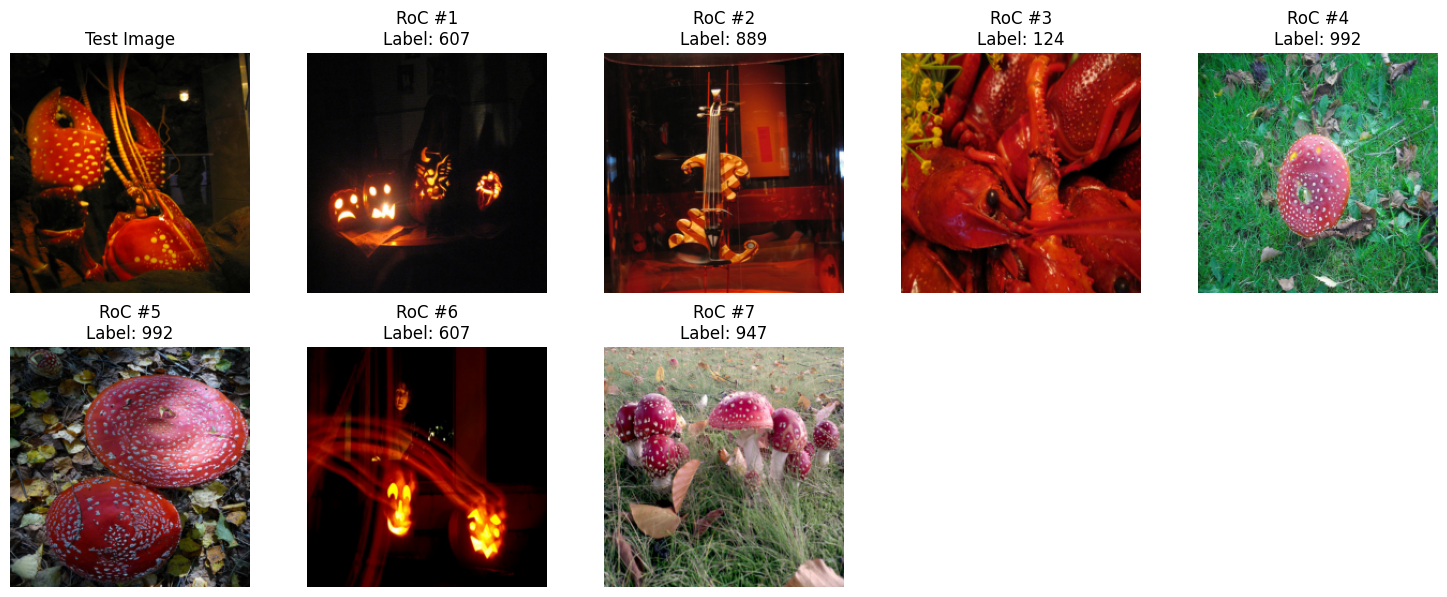

123

In [54]:
index = 248
print("True label: ", test_datasets['test1'][index][1])
des_model.predict_weighted_robust(test_datasets['test1'][index][0], k=7, return_logits=False, explain=True)


True label:  7

Explainability Report:
Model #0: VGG
  - Competence score: 0.8571
  - Cosine similarity: 0.9995
  - Combined weight: 0.1599
  - Predicted class: 8
--------------------------------------------------
Model #1: Inception3
  - Competence score: 0.8571
  - Cosine similarity: 0.5572
  - Combined weight: 0.0892
  - Predicted class: 7
--------------------------------------------------
Model #2: GoogLeNet
  - Competence score: 0.8571
  - Cosine similarity: 0.9946
  - Combined weight: 0.1591
  - Predicted class: 8
--------------------------------------------------
Model #3: MobileNetV2
  - Competence score: 0.8571
  - Cosine similarity: 0.9479
  - Combined weight: 0.1517
  - Predicted class: 8
--------------------------------------------------
Model #4: EfficientNet
  - Competence score: 0.8571
  - Cosine similarity: 0.9995
  - Combined weight: 0.1599
  - Predicted class: 8
--------------------------------------------------
Model #5: ResNet
  - Competence score: 0.8571
  - Cosine

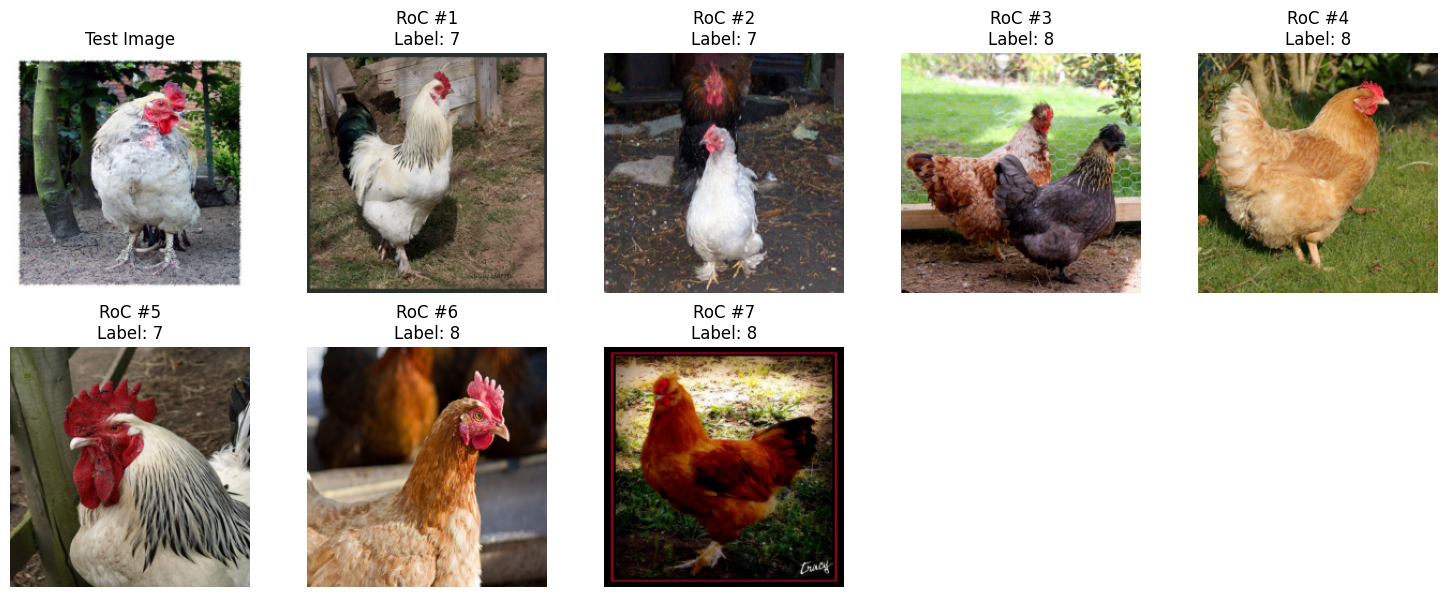

8

In [53]:
index = 14
print("True label: ", test_datasets['test1'][index][1])
des_model.predict_weighted_robust(test_datasets['test1'][index][0], k=7, return_logits=False, explain=True)


True label:  6

Explainability Report:
Model #0: VGG
  - Competence score: 0.5714
  - Cosine similarity: 0.7022
  - Combined weight: 0.1501
  - Predicted class: 973
--------------------------------------------------
Model #1: Inception3
  - Competence score: 0.5714
  - Cosine similarity: 0.3326
  - Combined weight: 0.0711
  - Predicted class: 750
--------------------------------------------------
Model #2: GoogLeNet
  - Competence score: 0.4286
  - Cosine similarity: 0.5105
  - Combined weight: 0.0818
  - Predicted class: 112
--------------------------------------------------
Model #3: MobileNetV2
  - Competence score: 0.7143
  - Cosine similarity: 0.6094
  - Combined weight: 0.1628
  - Predicted class: 980
--------------------------------------------------
Model #4: EfficientNet
  - Competence score: 0.8571
  - Cosine similarity: 0.5335
  - Combined weight: 0.1710
  - Predicted class: 6
--------------------------------------------------
Model #5: ResNet
  - Competence score: 0.5714
  

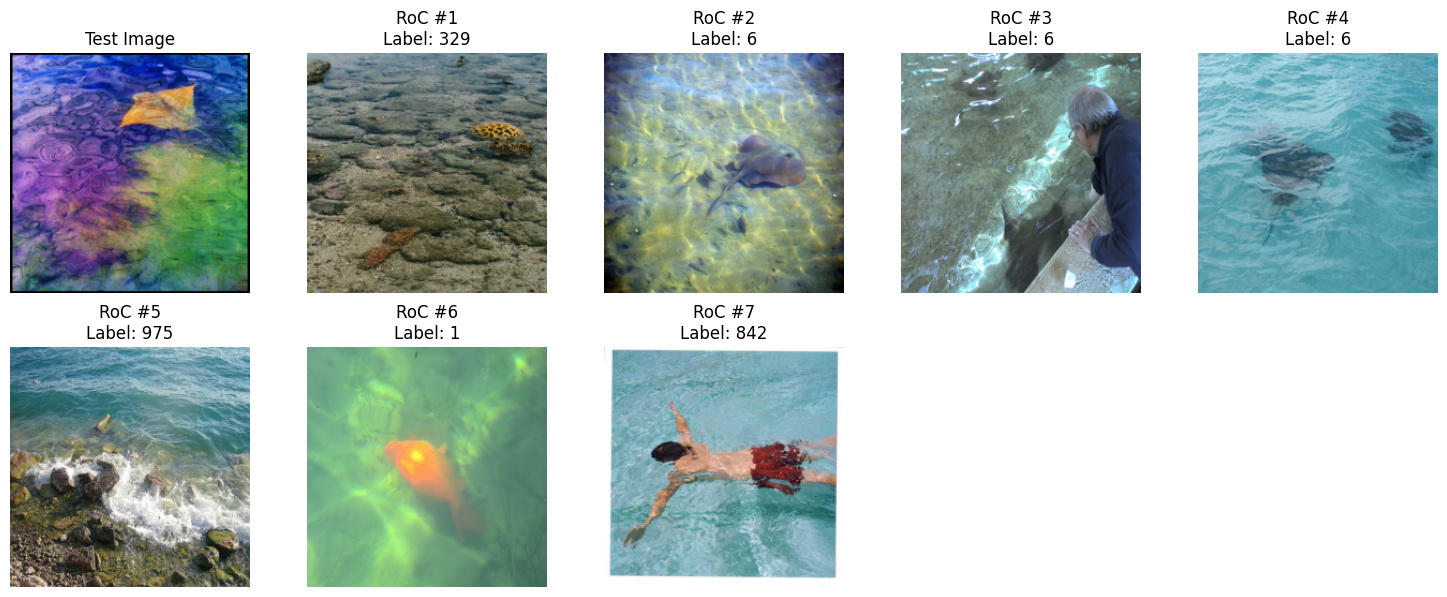

973

In [52]:
index = 12
print("True label: ", test_datasets['test1'][index][1])
des_model.predict_weighted_robust(test_datasets['test1'][index][0], k=7, return_logits=False, explain=True)


In [104]:
torch.from_numpy(x_test_adv).shape

torch.Size([1, 3, 224, 224])

In [177]:
class SoftVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images, return_probs=False):
        probs = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                softmaxed = torch.softmax(outputs, dim=1)
                probs.append(softmaxed.cpu().numpy())
        mean_probs = np.mean(np.stack(probs), axis=0)
        if return_probs:
            return mean_probs
        return np.argmax(mean_probs, axis=1)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        with torch.no_grad():
            model_probs = []
            for model in self.models:
                logits = model(image.to(self.device))
                softmaxed = torch.softmax(logits, dim=1)
                model_probs.append(softmaxed.cpu().numpy())
            mean_probs = np.mean(np.stack(model_probs), axis=0)
            probs = mean_probs[0]
            pred = np.argmax(probs)
            return probs, pred

In [165]:
from torch.utils.data import TensorDataset, DataLoader
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from collections import defaultdict


def evaluate_classifiers(pool, test_dataset, n_classes):
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    results = []

    for i, model in enumerate(pool):
        model = model.to(device)
        model.eval()
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                probs = torch.softmax(outputs, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(probs.cpu().numpy())

        acc = (np.array(y_true) == np.array(y_pred)).mean() * 100
        f1 = f1_score(y_true, y_pred, average='macro') * 100
        try:
            auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
        except ValueError:
            auc = float('nan')  # Handle single-class test sets

        results.append({
            'classifier': model.__class__.__name__,
            'accuracy': acc,
            'f1': f1,
            'auc': auc,
        })

    return results

In [166]:
def predict_for_ensembles(ensemble_model, test_loader, ens_type): 
    metrics = {
        'accuracy': [],
        'f1': [],
        'auc': []
    } 
    y_true, y_pred, y_prob = [], [], [] 

    for imgs, labels in tqdm(test_loader):
        img = imgs[0]
        label = labels.item()

        if ens_type == "soft": 
            probs, pred = ensemble_model.predict_single_with_probs(img)
        if ens_type == "des": 
            logits = ensemble_model.predict_weighted(img, return_logits=True)
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
        if ens_type == "des+": 
            logits = ensemble_model.predict_weighted_robust(img, return_logits=True)
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
    
        y_true.append(label)
        y_pred.append(pred)
        y_prob.append(probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
    except:
        auc = float('nan')

    print(f"{ens_type} Accuracy: {acc:.2f}%  | F1: {f1:.2f}%  | AUC: {auc:.2f}%")

    metrics['accuracy'].append(acc)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc) 
    # print(y_prob)

    return metrics

In [175]:
len(pool)

8

In [168]:
SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

total_start = time.time() 

selected_pool_indices = [0, 1, 2, 3, 4, 5, 6, 7]
TARGET_MODEL_INDEX = 1
EPSILON = 0.05

all_results = defaultdict(list) 

attacked_results = defaultdict(list)

des_metrics = []
soft_voting_metrics = [] 
des_plus_metrics = [] 
soft_voting_metrics_attacked = [] 
des_plus_metrics_attacked = []


pool = [trained_pool[i] for i in selected_pool_indices]  
des_model = VisionDES(val_dataset, pool)
des_model.fit()


for seed in SEEDS: 
    print(f"\n--- Test set: {seed} ---")

    seed_results = evaluate_classifiers(pool, test_datasets[f"test{seed}"], 1000)
    test_loader = DataLoader(test_datasets[f"test{seed}"], batch_size=1, shuffle=False, num_workers=4)   

    for res in seed_results:
        all_results[res['classifier']].append(res)

    # Build DES model
    des_metrics.append(predict_for_ensembles(des_model, test_loader, "des")) 

    # Soft Voting 
    # soft_ensemble = SoftVotingEnsemble(models=pool, device='cuda')  
    # soft_voting_metrics.append(predict_for_ensembles(soft_ensemble, test_loader, "soft")) 

    des_plus_metrics.append(predict_for_ensembles(des_model, test_loader, "des+")) 

    ### Attack =============================================================================================
    print("Attacked")
    target_model = pool[TARGET_MODEL_INDEX]  
    target_model = target_model.to(device).eval() 

    dummy_optimizer = torch.optim.Adam(target_model.parameters())
    loss_fn = nn.CrossEntropyLoss() 

    # Wrap it for ART
    art_classifier = PyTorchClassifier(
        model=target_model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(1, 224, 224),  
        nb_classes=1000,
        clip_values=(0.0, 1.0),
    )

    x_test = []
    y_test = []
    
    for img, label in test_datasets[f"test{seed}"]:
        x_test.append(img.numpy())
        y_test.append(label)
    
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=EPSILON, eps_step=0.01, max_iter=100)
    x_test_adv = pgd_attack.generate(x=x_test)

    adv_tensor = torch.tensor(x_test_adv).float()
    labels_tensor = torch.tensor(y_test).long()
    adv_dataset = TensorDataset(adv_tensor, labels_tensor)

    adv_test_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)  

    seed_attack_results = evaluate_classifiers(pool, adv_dataset, 1000) 
    for res in seed_attack_results:
        attacked_results[res['classifier']].append(res)


    # Soft Voting Atacked 
    # soft_ensemble = SoftVotingEnsemble(models=pool, device='cuda')  
    # soft_voting_metrics_attacked.append(predict_for_ensembles(soft_ensemble, adv_test_loader, "soft")) 
    
    des_plus_metrics_attacked.append(predict_for_ensembles(des_model, adv_test_loader, "des+"))    
    

total_end = time.time()
print(f"\n⏱️ Total time for all seeds: {(total_end - total_start) / 60:.2f} minutes")

100%|█████████████████████████████████████████████████████████████████| 938/938 [04:05<00:00,  3.81it/s]



--- Test set: 1 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:34<00:00,  2.45it/s]


des Accuracy: 76.35%  | F1: 74.55%  | AUC: 99.74%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:29<00:00,  6.07it/s]


des+ Accuracy: 76.90%  | F1: 75.07%  | AUC: 99.62%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:26<00:00,  6.12it/s]


des+ Accuracy: 76.20%  | F1: 74.49%  | AUC: 99.65%

--- Test set: 2 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:16<00:00,  2.51it/s]


des Accuracy: 77.55%  | F1: 75.76%  | AUC: 99.86%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:28<00:00,  6.09it/s]


des+ Accuracy: 77.45%  | F1: 75.64%  | AUC: 99.79%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:28<00:00,  6.09it/s]


des+ Accuracy: 76.60%  | F1: 74.72%  | AUC: 99.79%

--- Test set: 3 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:03<00:00,  2.55it/s]


des Accuracy: 79.45%  | F1: 77.89%  | AUC: 99.88%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:31<00:00,  6.03it/s]


des+ Accuracy: 79.75%  | F1: 78.21%  | AUC: 99.85%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:25<00:00,  6.15it/s]


des+ Accuracy: 78.80%  | F1: 77.01%  | AUC: 99.83%

--- Test set: 4 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [12:40<00:00,  2.63it/s]


des Accuracy: 78.45%  | F1: 76.84%  | AUC: 99.84%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:29<00:00,  6.06it/s]


des+ Accuracy: 78.20%  | F1: 76.51%  | AUC: 99.77%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:26<00:00,  6.13it/s]


des+ Accuracy: 77.45%  | F1: 75.74%  | AUC: 99.78%

--- Test set: 5 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:16<00:00,  2.51it/s]


des Accuracy: 77.70%  | F1: 75.26%  | AUC: 99.87%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:38<00:00,  5.90it/s]


des+ Accuracy: 78.00%  | F1: 75.64%  | AUC: 99.86%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:26<00:00,  6.13it/s]


des+ Accuracy: 77.95%  | F1: 75.53%  | AUC: 99.75%

--- Test set: 6 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:10<00:00,  2.53it/s]


des Accuracy: 76.55%  | F1: 74.71%  | AUC: 99.84%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:34<00:00,  5.98it/s]


des+ Accuracy: 76.90%  | F1: 75.00%  | AUC: 99.83%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:26<00:00,  6.12it/s]


des+ Accuracy: 76.70%  | F1: 74.68%  | AUC: 99.83%

--- Test set: 7 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [12:55<00:00,  2.58it/s]


des Accuracy: 77.95%  | F1: 76.11%  | AUC: 99.81%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:32<00:00,  6.01it/s]


des+ Accuracy: 77.85%  | F1: 75.96%  | AUC: 99.70%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:34<00:00,  5.98it/s]


des+ Accuracy: 77.20%  | F1: 75.27%  | AUC: 99.66%

--- Test set: 8 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:54<00:00,  2.40it/s]


des Accuracy: 76.95%  | F1: 74.45%  | AUC: 99.84%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:42<00:00,  5.83it/s]


des+ Accuracy: 76.75%  | F1: 74.34%  | AUC: 99.75%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:50<00:00,  5.71it/s]


des+ Accuracy: 76.00%  | F1: 73.48%  | AUC: 99.72%

--- Test set: 9 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:36<00:00,  2.45it/s]


des Accuracy: 75.90%  | F1: 73.95%  | AUC: 99.85%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:42<00:00,  5.85it/s]


des+ Accuracy: 76.10%  | F1: 74.10%  | AUC: 99.77%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:27<00:00,  6.10it/s]


des+ Accuracy: 75.10%  | F1: 72.80%  | AUC: 99.77%

--- Test set: 10 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:16<00:00,  2.51it/s]


des Accuracy: 77.30%  | F1: 75.32%  | AUC: 99.85%


100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:32<00:00,  6.01it/s]


des+ Accuracy: 77.95%  | F1: 76.14%  | AUC: 99.82%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [05:31<00:00,  6.03it/s]


des+ Accuracy: 76.85%  | F1: 74.88%  | AUC: 99.77%

⏱️ Total time for all seeds: 314.29 minutes


In [178]:
SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

total_start = time.time() 

selected_pool_indices = [0, 1, 2, 3, 4, 5, 6, 7]
TARGET_MODEL_INDEX = 1
EPSILON = 0.05

all_results = defaultdict(list) 

attacked_results = defaultdict(list)

des_metrics = []
soft_voting_metrics = [] 
des_plus_metrics = [] 
soft_voting_metrics_attacked = [] 
des_plus_metrics_attacked = []


pool = [trained_pool[i] for i in selected_pool_indices]  

for seed in SEEDS: 
    print(f"\n--- Test set: {seed} ---")

    seed_results = evaluate_classifiers(pool, test_datasets[f"test{seed}"], 1000)
    test_loader = DataLoader(test_datasets[f"test{seed}"], batch_size=1, shuffle=False, num_workers=4)   

    for res in seed_results:
        all_results[res['classifier']].append(res)

    # Soft Voting 
    soft_ensemble = SoftVotingEnsemble(models=pool, device='cuda')  
    soft_voting_metrics.append(predict_for_ensembles(soft_ensemble, test_loader, "soft")) 

    ### Attack =============================================================================================
    print("Attacked")
    target_model = pool[TARGET_MODEL_INDEX]  
    target_model = target_model.to(device).eval() 

    dummy_optimizer = torch.optim.Adam(target_model.parameters())
    loss_fn = nn.CrossEntropyLoss() 

    # Wrap it for ART
    art_classifier = PyTorchClassifier(
        model=target_model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(1, 224, 224),  
        nb_classes=1000,
        clip_values=(0.0, 1.0),
    )

    x_test = []
    y_test = []
    
    for img, label in test_datasets[f"test{seed}"]:
        x_test.append(img.numpy())
        y_test.append(label)
    
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=EPSILON, eps_step=0.01, max_iter=100)
    x_test_adv = pgd_attack.generate(x=x_test)

    adv_tensor = torch.tensor(x_test_adv).float()
    labels_tensor = torch.tensor(y_test).long()
    adv_dataset = TensorDataset(adv_tensor, labels_tensor)

    adv_test_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)  

    seed_attack_results = evaluate_classifiers(pool, adv_dataset, 1000) 
    for res in seed_attack_results:
        attacked_results[res['classifier']].append(res)


    # Soft Voting Atacked 
    soft_ensemble = SoftVotingEnsemble(models=pool, device='cuda')  
    soft_voting_metrics_attacked.append(predict_for_ensembles(soft_ensemble, adv_test_loader, "soft")) 
        

total_end = time.time()
print(f"\n⏱️ Total time for all seeds: {(total_end - total_start) / 60:.2f} minutes")


--- Test set: 1 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:44<00:00, 19.19it/s]


soft Accuracy: 76.70%  | F1: 74.91%  | AUC: 99.72%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:48<00:00, 18.50it/s]


soft Accuracy: 76.25%  | F1: 74.49%  | AUC: 99.74%

--- Test set: 2 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:42<00:00, 19.42it/s]


soft Accuracy: 77.05%  | F1: 75.15%  | AUC: 99.86%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:48<00:00, 18.36it/s]


soft Accuracy: 76.60%  | F1: 74.69%  | AUC: 99.85%

--- Test set: 3 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:42<00:00, 19.46it/s]


soft Accuracy: 79.25%  | F1: 77.47%  | AUC: 99.88%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:48<00:00, 18.48it/s]


soft Accuracy: 78.40%  | F1: 76.45%  | AUC: 99.84%

--- Test set: 4 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:42<00:00, 19.45it/s]


soft Accuracy: 78.05%  | F1: 76.33%  | AUC: 99.81%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:46<00:00, 18.74it/s]


soft Accuracy: 77.40%  | F1: 75.74%  | AUC: 99.79%

--- Test set: 5 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:39<00:00, 20.05it/s]


soft Accuracy: 77.95%  | F1: 75.48%  | AUC: 99.87%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:48<00:00, 18.46it/s]


soft Accuracy: 78.05%  | F1: 75.62%  | AUC: 99.84%

--- Test set: 6 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:38<00:00, 20.26it/s]


soft Accuracy: 76.50%  | F1: 74.49%  | AUC: 99.88%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:50<00:00, 18.03it/s]


soft Accuracy: 76.15%  | F1: 74.17%  | AUC: 99.87%

--- Test set: 7 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:46<00:00, 18.82it/s]


soft Accuracy: 77.90%  | F1: 75.96%  | AUC: 99.81%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:51<00:00, 17.90it/s]


soft Accuracy: 76.50%  | F1: 74.48%  | AUC: 99.79%

--- Test set: 8 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:45<00:00, 18.91it/s]


soft Accuracy: 76.45%  | F1: 74.01%  | AUC: 99.82%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:51<00:00, 17.86it/s]


soft Accuracy: 75.70%  | F1: 73.14%  | AUC: 99.80%

--- Test set: 9 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.96it/s]


soft Accuracy: 76.05%  | F1: 74.09%  | AUC: 99.82%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:47<00:00, 18.61it/s]


soft Accuracy: 74.70%  | F1: 72.38%  | AUC: 99.79%

--- Test set: 10 ---


100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:39<00:00, 20.14it/s]


soft Accuracy: 77.70%  | F1: 75.83%  | AUC: 99.85%
Attacked


PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:47<00:00, 18.56it/s]


soft Accuracy: 76.75%  | F1: 74.79%  | AUC: 99.83%

⏱️ Total time for all seeds: 103.94 minutes


In [169]:
import pandas as pd 

summary = []

for clf_name, metrics_list in all_results.items():
    accs = [m['accuracy'] for m in metrics_list]
    f1s = [m['f1'] for m in metrics_list]
    aucs = [m['auc'] for m in metrics_list]

    summary.append({
        'Classifier': clf_name,
        'Accuracy': f"{np.mean(accs):.2f} ± {np.std(accs):.2f}",
        'F1': f"{np.mean(f1s):.2f} ± {np.std(f1s):.2f}",
        'AUC': f"{np.mean(aucs):.2f} ± {np.std(aucs):.2f}",
    })

df_summary = pd.DataFrame(summary)
print(df_summary)

     Classifier      Accuracy            F1           AUC
0    Inception3  67.47 ± 0.84  64.97 ± 0.93  98.96 ± 0.09
1     GoogLeNet  58.39 ± 1.15  55.64 ± 1.21  99.22 ± 0.11
2   MobileNetV2  69.66 ± 1.59  67.45 ± 1.78  99.71 ± 0.05
3  EfficientNet  75.85 ± 0.90  73.88 ± 1.04  99.72 ± 0.05
4        ResNet  72.32 ± 3.46  70.14 ± 3.67  99.73 ± 0.08


In [170]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in des_metrics] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final DES Performance (across seeds) ===")
print(df_summary)


=== Final DES Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  77.41 ± 1.00
1        F1  75.48 ± 1.14
2       AUC  99.84 ± 0.04


In [171]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in des_plus_metrics] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final DES+ Performance (across seeds) ===")
print(df_summary)


=== Final DES+ Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  77.59 ± 0.96
1        F1  75.66 ± 1.12
2       AUC  99.78 ± 0.07


In [179]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in soft_voting_metrics] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final SOFT Performance (across seeds) ===")
print(df_summary)


=== Final SOFT Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  77.36 ± 0.93
1        F1  75.37 ± 1.02
2       AUC  99.83 ± 0.05


# <div style="color:white;display:fill;border-radius:5px;background-color:#f02263;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b></b> Adversarial Attack Results</p></div>

In [172]:
import pandas as pd 

summary = []

for clf_name, metrics_list in attacked_results.items():
    accs = [m['accuracy'] for m in metrics_list]
    f1s = [m['f1'] for m in metrics_list]
    aucs = [m['auc'] for m in metrics_list]

    summary.append({
        'Classifier': clf_name,
        'Accuracy': f"{np.mean(accs):.2f} ± {np.std(accs):.2f}",
        'F1': f"{np.mean(f1s):.2f} ± {np.std(f1s):.2f}",
        'AUC': f"{np.mean(aucs):.2f} ± {np.std(aucs):.2f}",
    })

df_summary = pd.DataFrame(summary)
print(df_summary)

     Classifier      Accuracy            F1           AUC
0    Inception3  66.88 ± 0.90  64.38 ± 0.97  98.93 ± 0.09
1     GoogLeNet   9.56 ± 0.84   8.72 ± 0.72  64.34 ± 0.53
2   MobileNetV2  68.75 ± 1.37  66.44 ± 1.56  99.70 ± 0.05
3  EfficientNet  75.14 ± 0.84  73.17 ± 1.03  99.71 ± 0.06
4        ResNet  71.41 ± 3.63  69.17 ± 3.86  99.73 ± 0.09


In [173]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in des_plus_metrics_attacked] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final DES+ Performance (across seeds) ===")
print(df_summary)


=== Final DES+ Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  76.89 ± 0.99
1        F1  74.86 ± 1.11
2       AUC  99.76 ± 0.06


In [180]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in soft_voting_metrics_attacked] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final SOFT Performance (across seeds) ===")
print(df_summary)


=== Final SOFT Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  76.65 ± 1.04
1        F1  74.59 ± 1.15
2       AUC  99.81 ± 0.04
